# Assignment Q3

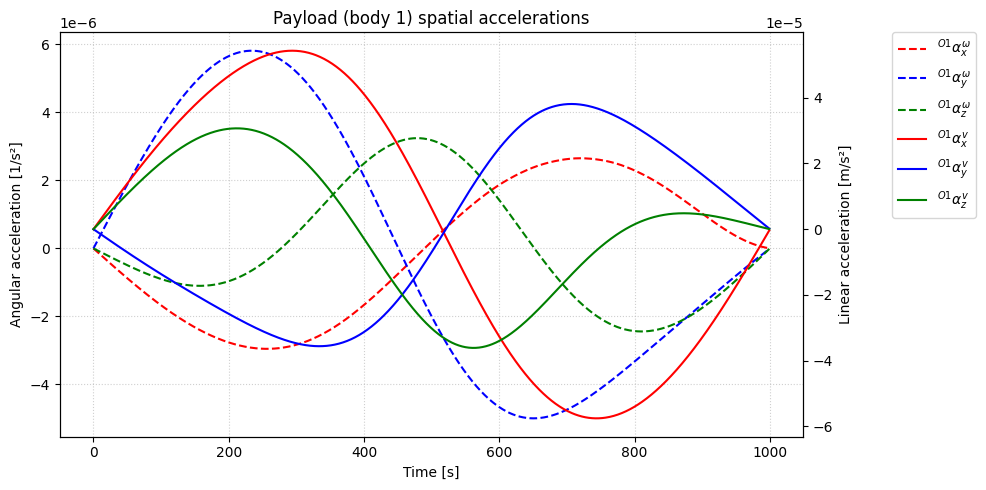

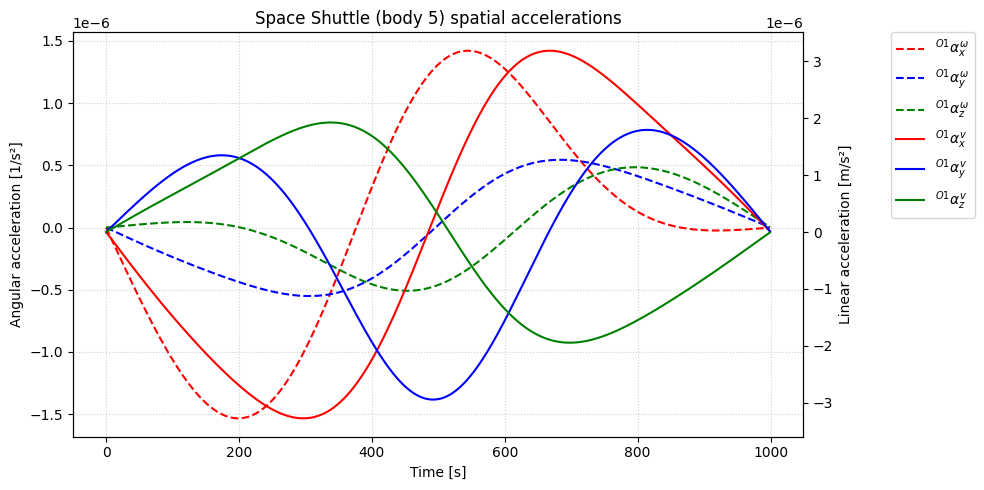

Lidt fejl i plots, ikke tag dig af det, vi har en plotting function.


In [19]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import utils as ut

# Number of bodies in the simulation
nbodies = 5

# Time span for the simulation
tspan = np.arange(0, 1000, 1)

# Initial state vector (positions and orientations)
theta0 = np.array([0, 0, 0, 1, np.pi/4, np.pi/4, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
# Initial velocity vector (linear and angular velocities)
beta0 = np.zeros(14)
# Combine initial state and velocity into a single state vector
state0 = np.concatenate((theta0, beta0))

# Function to convert hinge angles to quaternions
def qfromtheta(theta,hingenum):

    if hingenum == 1 or hingenum == 4:
        return theta.flatten()

    elif hingenum == 2 or hingenum == 3:
        n = np.array([1, 0, 0])  # Axis of rotation (x-axes are colinear)
        return np.array([
            *(np.sin(theta/2) * n).flatten(), 
            np.cos(theta/2).item()
        ])

    elif hingenum == 5:
        # NB: generazlied coordinates for body 5 consists of both rotation and translation, hence only the 4 first entries.
        return theta[:4].flatten()

def hingediff(theta,beta,hingenum):
    if hingenum == 1 or hingenum == 4:
        # Normalize quaternion
        theta = theta / np.linalg.norm(theta)
        # Reshape beta to column vector for matrix multiplication compatibility
        beta = beta.reshape(3,1)
        theta_dot = 0.5 * np.block([[-ut.skewfromvec(beta), beta],[-beta.T, 0]]) @ theta
        return theta_dot
    elif hingenum == 2 or hingenum == 3:
        theta_dot = beta
        return theta_dot
    elif hingenum == 5:
        theta_dot = np.zeros(7)
        # Normalize quaternion
        theta_rot = theta[:4] / np.linalg.norm(theta[:4])
        # Reshape beta to column vector for matrix multiplication compatibility
        beta_rot = beta[:3].reshape(3,1)
        theta_dot[:4] = 0.5 * np.block([[-ut.skewfromvec(beta_rot), beta_rot],[-beta_rot.T, 0]]) @ theta_rot
        theta_dot[4:] = beta[3:].flatten()
        return theta_dot

def ATBI(theta,beta,tau):
    # Initialize mass array for each body
    m = [None] * nbodies
    m[0] = 14520
    m[1] = 400
    m[2] = m[1]
    m[3] = m[1]
    m[4] = 294e3

    # Position of center of gravity relative to body frame in body frame:
    CGpos = [None] * nbodies
    CGpos[0] = np.array([0, 0, 0.7])
    CGpos[1] = np.array([0, 0, 2.5])
    CGpos[2] = CGpos[1]
    CGpos[3] = CGpos[1]
    CGpos[4] = np.array([0, 0, 0])

    # Position of outgoing hinge frame (body frame) relative to incoming hinge frame in body frame:
    Hpos = [None] * nbodies
    Hpos[0] = np.array([0, 0, 0])
    Hpos[1] = np.array([0, 0, 5])
    Hpos[2] = Hpos[1]
    Hpos[3] = Hpos[1]
    Hpos[4] = np.array([12, 4, 2])

    # 2nd order moment of inertia for each body in the CG frame:
    J = [None] * nbodies
    J[0] = np.diag([1.01, 1.51, 0.331]) * 1e4
    J[1] = np.diag([834, 834, 0.72])
    J[2] = J[1]
    J[3] = J[1]
    J[4] = np.diag([3.87, 29.04, 30.30]) * 1e6

    # Defining hinge-maps:
    H = [None] * nbodies
    H[0] = np.block([np.eye(3), np.zeros((3, 3))])
    H[1] = np.array([1, 0, 0, 0, 0, 0]).reshape(1, 6)
    H[2] = H[1]
    H[3] = H[0]
    H[4] = np.eye(6)

    # Rigid body transforms to move mass matrices from CG (where they are built) to body frame.
    O_phi_CG = [ut.rigidbodytransform(pos) for pos in CGpos]

    # Building spatial inertia matrices at body frame in body frame:
    M = [phi @ np.block([[J, np.zeros((3, 3))],
                         [np.zeros((3, 3)), m*np.eye(3)]]) @ phi.T for phi, J, m in zip(O_phi_CG, J, m)]
    
    # Building spatial vector q which holds quaternions for all bodies:
    q = [qfromtheta(t, j+1) for j, t in enumerate(theta)]

    # Preparing cells for values to store:
    V = [None] * nbodies
    agothic = [None] * nbodies
    bgothic = [None] * nbodies

    # Kinematics scatter:
    for k in reversed(range(nbodies)):
        # Rotation from child to parent:
        pRc = ut.spatialrotfromquat(q[k])
        # Rotation from parent to child:
        cRp = pRc.T

        # Rel. spatial vel. across hinge:
        Delta_V = H[k].T @ beta[k]

        # Spatial velocities (using if statement to enforce V(0)=0):
        if k == nbodies - 1:
            V[k] = Delta_V
        else:
            phi = ut.rigidbodytransform(Hpos[k+1])
            V[k] = cRp @ phi.T @ V[k+1] + Delta_V

        # Coriolis term (const. joint map and pure rotation):
        if k == nbodies - 1:
            agothic[k] = ut.skewfromspatialvec(V[k]) @ Delta_V - ut.skewbarfromspatialvec(Delta_V) @ Delta_V
        else:
            agothic[k] = ut.skewfromspatialvec(V[k]) @ Delta_V

        # Gyroscopic term:
        bgothic[k] = ut.skewbarfromspatialvec(V[k]) @ M[k] @ V[k]

    # Preparing cells for values to store:
    Pplus = [None] * nbodies
    G = [None] * nbodies
    nu = [None] * nbodies
    varepsplus = [None] * nbodies
    alpha = [None] * nbodies
    gamma = [None] * nbodies

    # ATBI gather (using if statement to enforce Pplus(0)=0, varepsplus(0)=0):
    for k in range(nbodies):
        if k == 0:
            P = M[k]
            D = H[k] @ P @ H[k].T
            G[k] = P @ H[k].T @ np.linalg.inv(D)
            taubar = np.eye(6) - G[k] @ H[k]
            Pplus[k] = taubar @ P
            vareps = P @ agothic[k] + bgothic[k]
            eps = tau[k] - H[k] @ vareps
            nu[k] = np.linalg.inv(D) @ eps
            varepsplus[k] = vareps + G[k] @ eps
        else:
            # Rotation from parent to child:
            pRc = ut.spatialrotfromquat(q[k-1])
            # Rotation from child to parent:
            cRp = pRc.T
            # Rigid body transform:
            phi = ut.rigidbodytransform(Hpos[k])

            P = phi @ pRc @ Pplus[k-1] @ cRp @ phi.T + M[k]
            D = H[k] @ P @ H[k].T
            G[k] = P @ H[k].T @ np.linalg.inv(D)
            taubar = np.eye(6) - G[k] @ H[k]
            Pplus[k] = taubar @ P
            vareps = phi @ pRc @ varepsplus[k-1] + P @ agothic[k] + bgothic[k]
            eps = tau[k] - H[k] @ vareps
            nu[k] = np.linalg.inv(D) @ eps
            varepsplus[k] = vareps + G[k] @ eps

    # ATBI scatter (using if statement to enforce alpha(n+1)=0):
    for k in reversed(range(nbodies)):
        if k == nbodies - 1:
            alphaplus = np.zeros(6)
            gamma[k] = nu[k] - G[k].T @ alphaplus
            alpha[k] = alphaplus + H[k].T @ gamma[k] + agothic[k]
        else:
            # Rotation from child to parent:
            pRc = ut.spatialrotfromquat(q[k])
            # Rotation from parent to child:
            cRp = pRc.T
            # Rigid body transform:
            phi = ut.rigidbodytransform(Hpos[k+1])

            alphaplus = cRp @ phi.T @ alpha[k+1]
            gamma[k] = nu[k] - G[k].T @ alphaplus
            alpha[k] = alphaplus + H[k].T @ gamma[k] + agothic[k]
    return alpha, gamma

# Function to interpolate generalized forces from CSV file
def interp_gen_forces(t):
    # 1. Load the data (Equivalent to readtable)
    data = pd.read_csv("generalized_forces.csv")
    
    # Extract time for convenience
    time_pts = data['time'].values
    
    # 2. Define a helper for linear interpolation
    # 'fill_value="extrapolate"' allows it to work outside bounds if needed,
    # though interp1 in MATLAB defaults to NaN or error depending on version.
    def get_val(column_name):
        f = interp1d(time_pts, data[column_name].values, kind='linear')
        return float(f(t))

    # 3. Replicate the tau cell array (5 elements)
    tau = [None] * nbodies
    
    # tau{1}: 3x1 vector
    tau[0] = np.array([
        get_val('body_1_moment_x'),
        get_val('body_1_moment_y'),
        get_val('body_1_moment_z')
    ])
    
    # tau{2}: scalar (or 1x1)
    tau[1] = get_val('body_2_moment')
    
    # tau{3}: scalar (or 1x1)
    tau[2] = get_val('body_3_moment')
    
    # tau{4}: 3x1 vector
    tau[3] = np.array([
        get_val('body_4_moment_x'),
        get_val('body_4_moment_y'),
        get_val('body_4_moment_z')
    ])
    
    # tau{5}: 6x1 zero vector
    tau[4] = np.zeros(6)
    
    return tau

# Ordinary differential equation function
def odefun(t,state):
    # Unpack state vector
    theta = [None] * nbodies
    beta = [None] * nbodies
    theta[0] = state[0:4]
    theta[1] = state[4:5]
    theta[2] = state[5:6]
    theta[3] = state[6:10]
    theta[4] = state[10:17]
    beta[0] = state[17:20]
    beta[1] = state[20:21]
    beta[2] = state[21:22]
    beta[3] = state[22:25]
    beta[4] = state[25:]

    # Detmining theta_dot
    theta_dot = [None] * nbodies
    for j in range(nbodies):
        theta_dot[j] = hingediff(theta[j], beta[j], j+1)

    # Detmining beta_dot
    tau = interp_gen_forces(t)
    _, beta_dot = ATBI(theta, beta, tau)

    # Pack theta_dot and beta_dot into state_dot
    state_dot = np.zeros_like(state)
    state_dot = np.concatenate((
        theta_dot[0], theta_dot[1], theta_dot[2], theta_dot[3], theta_dot[4],
        beta_dot[0], beta_dot[1], beta_dot[2], beta_dot[3], beta_dot[4]
    ))
    return state_dot.flatten()
    
# Solve the ODE using scipy's solve_ivp
result = solve_ivp(odefun, t_span=(0, tspan[-1]), y0=state0, method='RK45', t_eval=tspan)
# Extract time and state vectors
time_points = result.t
state_values = result.y  # Shape will be (number_of_states, len(tspan))

# Extract spatial accelerations for body 1 and body 5
alpha1 = np.zeros((6, tspan.shape[0]))
alpha5 = np.zeros((6, tspan.shape[0]))
for t in time_points:
    # Unpack state vector at time t
    theta = [None] * nbodies
    beta = [None] * nbodies
    theta[0] = state_values[0:4, int(t)]
    theta[1] = state_values[4:5, int(t)]
    theta[2] = state_values[5:6, int(t)]
    theta[3] = state_values[6:10, int(t)]
    theta[4] = state_values[10:17, int(t)]
    beta[0] = state_values[17:20, int(t)]
    beta[1] = state_values[20:21, int(t)]
    beta[2] = state_values[21:22, int(t)]
    beta[3] = state_values[22:25, int(t)]
    beta[4] = state_values[25:, int(t)]
    tau = interp_gen_forces(t)
    alpha_temp, _ = ATBI(theta, beta, tau)

    # Save alpha for body 1 and 5
    alpha1[:, int(t)] = alpha_temp[0]  # Body 1
    alpha5[:, int(t)] = alpha_temp[4]  # Body 5


def plot_spatial_accelerations(time, alpha_data, body_name):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # 1. Plot Angular Accelerations (Left Y-axis) - Dashed lines
    lns1 = ax1.plot(time, alpha_data[0, :], 'r--', label=r'$^{O1}\alpha_x^\omega$')
    lns2 = ax1.plot(time, alpha_data[1, :], 'b--', label=r'$^{O1}\alpha_y^\omega$')
    lns3 = ax1.plot(time, alpha_data[2, :], 'g--', label=r'$^{O1}\alpha_z^\omega$')

    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Angular acceleration [1/s²]')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.grid(True, linestyle=':', alpha=0.6)

    # 2. Plot Linear Accelerations (Right Y-axis) - Solid lines
    ax2 = ax1.twinx()
    lns4 = ax2.plot(time, alpha_data[3, :], 'r-', label=r'$^{O1}\alpha_x^v$')
    lns5 = ax2.plot(time, alpha_data[4, :], 'b-', label=r'$^{O1}\alpha_y^v$')
    lns6 = ax2.plot(time, alpha_data[5, :], 'g-', label=r'$^{O1}\alpha_z^v$')

    ax2.set_ylabel('Linear acceleration [m/s²]')
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # 3. Combine legends and move OUTSIDE the plot
    lns = lns1 + lns2 + lns3 + lns4 + lns5 + lns6
    labs = [l.get_label() for l in lns]
    
    # loc='upper left' with bbox_to_anchor=(1.1, 1) places it to the right of the axes
    ax1.legend(lns, labs, loc='upper left', bbox_to_anchor=(1.12, 1), borderaxespad=0.)

    plt.title(f'{body_name} spatial accelerations')
    
    # Adjust layout to make room for the external legend
    plt.tight_layout()
    plt.show()

# --- Generate Plots ---

# For Payload (Body 1)
plot_spatial_accelerations(time_points, alpha1, "Payload (body 1)")

# For Space Shuttle (Body 5)
plot_spatial_accelerations(time_points, alpha5, "Space Shuttle (body 5)")

print("Lidt fejl i plots, ikke tag dig af det, vi har en plotting function.")